In [1]:
# Python SQL toolkit and Object Relational Mapper, Pyplot, Pandas and Datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

import pandas as pd
import datetime as dt

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [4]:
# Assign our tables to a class in a variable according to their names
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create a session to query our tables
session = Session(engine)

# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [5]:
#Get table names
inspector.get_table_names()

['measurement', 'station']

In [6]:
#inspect station table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
#inspect measurement table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
#Dates of our 'trip'
start_date = '2017-06-01'
end_date = '2017-06-14'

# Climate Analysis and Exploration

### Precipitation Analysis

>- Last 12 months of precipitation data and the dates of measurement
   This will be stored in a DataFrame and plotted below

In [9]:
# Store and show the last measurement date
last_test_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_test_date

'2017-08-23'

[]

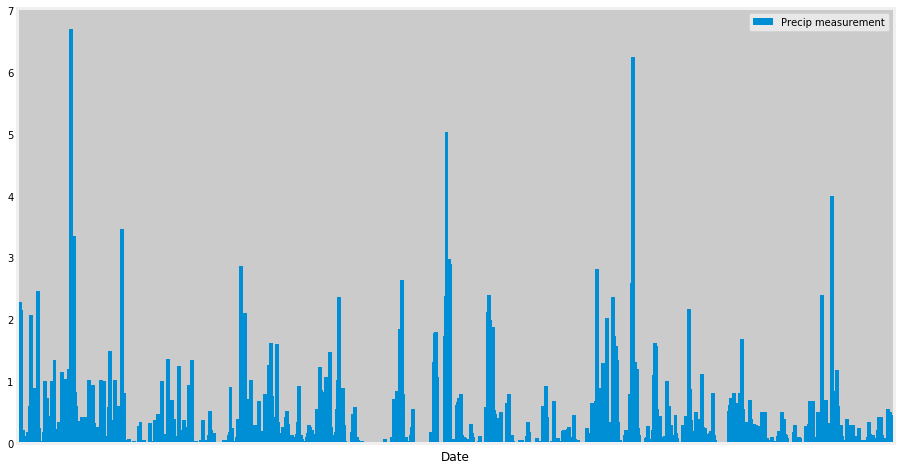

In [10]:
# Query for the time frame of one year
last_12_months_of_precip_data = session.query(Measurement.date, Measurement.prcp)\
      .filter(Measurement.date > '2016-08-23').all()

# Store in a dataFrame and set date as index for plotting
last_12_months_of_precip_data_df = pd.DataFrame(last_12_months_of_precip_data, columns=['Date', 'Precip measurement'])\
    .set_index('Date')

last_12_months_of_precip_data_df.sort_values(by='Date', inplace=True)
last_12_months_of_precip_data_df

last_12_months_of_precip_data_df_plot = last_12_months_of_precip_data_df.plot.bar(figsize=(14,8), width=10)
last_12_months_of_precip_data_df_plot.set_xlabel('Date')
last_12_months_of_precip_data_df_plot.set_xticklabels([], visible=False)

#### Summary statistics for the precipitation data

In [11]:
last_12_months_of_precip_data_df['Precip measurement'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precip measurement, dtype: float64

# Station Analysis

#### Query to calculate the total number of stations

In [12]:
total_stations = session.query(Station.id).count()
print(f'There are {total_stations} total stations')

There are 9 total stations


#### Station with the highest number of observations

In [13]:
stations_measurement_counts = session.query(Measurement.station, func.count(Measurement.date))\
                                     .group_by(Measurement.station)\
                                     .order_by(func.count(Measurement.date).desc())\
                                     .all()

In [14]:
print(f'station {stations_measurement_counts[0][0]} is the most active station \
with {stations_measurement_counts[0][1]} observations')

station USC00519281 is the most active station with 2772 observations


#### Here are the stations and their obsevation counts in descending order

In [15]:
stations_measurement_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

#### Design a query to retrieve the last 12 months of temperature observation data (tobs) from the station with the most readings, station USC00519281.
>- Plotted with a histogram using bin size of 12

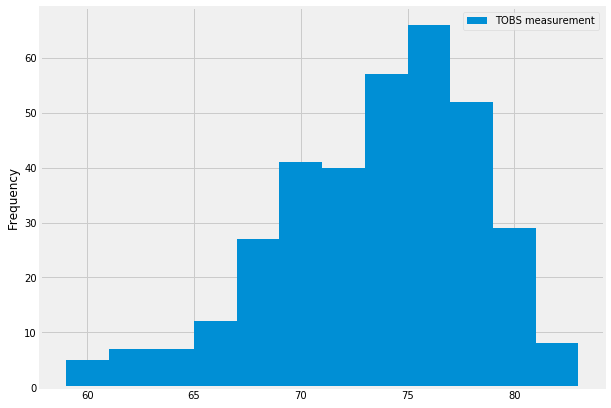

In [16]:
# Same query as for precip data but for TOBS this time and filtered by the station with the most measurements
last_12_months_of_tobs_data_df = pd.DataFrame(session.query(Measurement.station, Measurement.date, Measurement.tobs)\
      .filter(Measurement.date > '2016-08-23')\
      .filter(Measurement.station == 'USC00519281')\
      .all(), columns=['Station', 'Date', 'TOBS measurement'])

tobs_hist = last_12_months_of_tobs_data_df.plot(kind='hist', figsize=(9,7), bins=12)




In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [18]:
trip_avg_temp = list(calc_temps(start_date, end_date)[0])
trip_avg_temp

[72.0, 77.44444444444444, 83.0]